In [1]:
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt

dem_fname = 'rcew_dem_5m_.tif'
nbins = 35

In [2]:
rcew_dem = rio.open(dem_fname)
rcew_dem

<open DatasetReader name='rcew_dem_5m_.tif' mode='r'>

In [3]:
rcew_dem.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -3.402823e+38,
 'width': 2940,
 'height': 5750,
 'count': 1,
 'crs': CRS.from_epsg(26911),
 'transform': Affine(5.0, 0.0, 511030.85,
        0.0, -5.0, 4795946.63)}

In [4]:
!ls

HydroShareResourceDemo.ipynb	rcew_dem_5m_.tif
IntroToHydroPython_Stork.ipynb	rcew_dem_5m_.tif.ovr
mod02_assignment_PAS.ipynb	rcew_dem_5m_.tif.xml
mod03-spatial-data.ipynb	rcew_dem_5m.zip
mod04.ipynb			README.md
my_streamflow_data_PAS.pkl	streamflow_data_06752260.pkl
NB1_TimeSeriesAnalysis.ipynb	streamflow_data_09085000.pkl
NotSureYet.ipynb		Untitled1.ipynb
rcew_dem_5m_.tfw		Untitled.ipynb


In [5]:
rcew_elev = rcew_dem.read(1)
rcew_elev

array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]], dtype=float32)

In [6]:
rcew_elev = np.where(rcew_elev<0, np.nan, rcew_elev) #overwrites what you've read in; flags nans to make filtering of data easier; assigns nans to values less than 0

<function matplotlib.pyplot.show(close=None, block=None)>

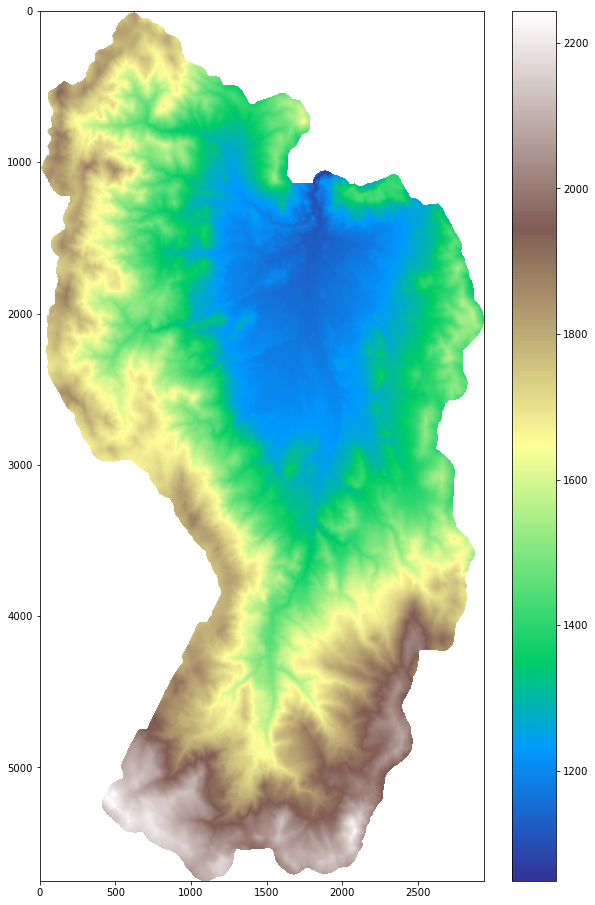

In [7]:
plt.figure(figsize=(10,16))
plt.imshow(rcew_elev, cmap='terrain') #chose a color map from online key
plt.colorbar()
plt.show

### Compute the hypsometric curve
#### the percent of the area that is above a particular elevation area

#### the shape of this curve tells us a lot about the watershed's characteristics, e.g. how climate change may affect the watershed

In [8]:
#need shorthand way to remove nan values so that histogram can read data
f_elev, b_elev = np.histogram(rcew_elev[~np.isnan(rcew_elev)], bins=nbins) #default number of bins is 10, but we can set our own; need shorthand way to remove nan values so that histogram can read data ~np.isnan
print(f_elev)
print(b_elev)

[  1619  11914 152342 438122 594588 501777 456786 510649 470118 430887
 471721 469855 477990 427215 363346 354675 396460 423829 457140 434510
 417715 476529 390886 251801 185235 169748 164541 182518 173834 153810
 170081 113015  91200  42992  10121]
[1048.7723 1082.9165 1117.0605 1151.2047 1185.3489 1219.4929 1253.6371
 1287.7812 1321.9253 1356.0695 1390.2136 1424.3577 1458.5018 1492.646
 1526.79   1560.9342 1595.0784 1629.2224 1663.3666 1697.5106 1731.6548
 1765.799  1799.943  1834.0872 1868.2313 1902.3754 1936.5195 1970.6637
 2004.8077 2038.9519 2073.096  2107.2402 2141.3843 2175.5283 2209.6726
 2243.8167]


36
35


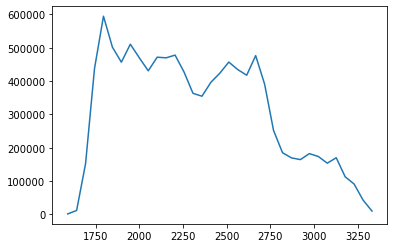

In [22]:
print(b_elev.size)
print(f_elev.size) #need to have same sized data so they play nicely together
bin_centers = (b_elev[0:-1]+ b_elev[1:]/2)
plt.plot(bin_centers, f_elev)
#bin_centers = b_elev[0:-2] + b_elev[1:-1]/2 #going from the 0th element to the -1 element, you go from the start to the end back to the first
#print(bin_centers.size)
#plt.bar(bin_centers, f_elev)

In [21]:
hypso_rcew = 1.0 -np.cumsum(f_elev/np.sum(f_elev))
hypso_rcew

array([ 9.99850640e-01,  9.98751519e-01,  9.84697270e-01,  9.44278504e-01,
        8.89425032e-01,  8.43133800e-01,  8.00993194e-01,  7.53883480e-01,
        7.10512936e-01,  6.70761633e-01,  6.27243205e-01,  5.83896924e-01,
        5.39800153e-01,  5.00387608e-01,  4.66867271e-01,  4.34146874e-01,
        3.97571619e-01,  3.58471448e-01,  3.16298185e-01,  2.76212643e-01,
        2.37676516e-01,  1.93714529e-01,  1.57653501e-01,  1.34423703e-01,
        1.17334924e-01,  1.01674891e-01,  8.64952287e-02,  6.96571054e-02,
        5.36201209e-02,  3.94304423e-02,  2.37396893e-02,  1.33135367e-02,
        4.89991807e-03,  9.33708711e-04, -2.22044605e-16])

Text(0, 0.5, 'Fraction of area above [-]')

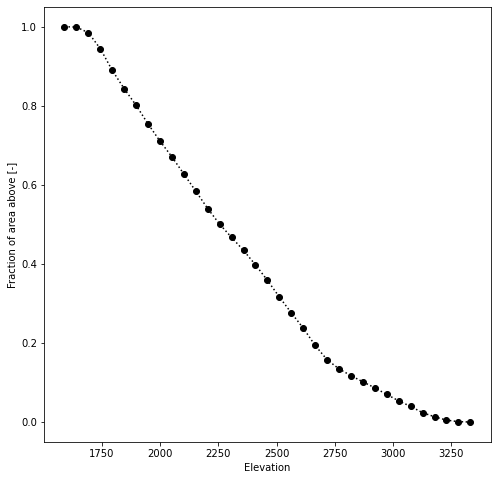

In [11]:
plt.figure(figsize=(8,8))
plt.plot(bin_centers,hypso_rcew, 'ko:')
plt.xlabel('Elevation')
plt.ylabel('Fraction of area above [-]') #area because all our pixels are the same size

### Algorithm for visualizing bottom and top 1/3 of elevation (area bc pixels are all the same)
1. Find elevation corresponding to hypsometric curve values of (1/3) and 2/3), using 'np.interp()' z_33 and z_66
2. use the 'np.where(rcew_elev<z_66, , )' to get the bottom 1/3 of elevations, then to get the top third...
3. use 'plt.imshow()' to plot the DEMs of the top and bottom 1/3 of watershed

In [23]:
z_33 = np.interp(0.33, hypso_rcew, bin_centers)
z_33

3331.5810546875

In [15]:
z_66 = np.interp(0.67, hypso_rcew, bin_centers)
z_66

3331.5810546875

In [20]:
xp = [1, 2, 3]
fp = [3, 2, 0]
np.interp(2.5, xp, fp)

1.0